In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_2642292/2817862154.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:

def postprocess_df(series, exclude_keys=None):
    """
    Takes a pandas Series with a MultiIndex and folds over all keys except for those specified
    in `exclude_keys` by concatenating the key name and its value into the 'algo' column values.

    Parameters:
    - series: pandas.Series with a MultiIndex.
    - exclude_keys: list of strings representing keys to exclude from the folding process.

    Returns:
    - A DataFrame with 'algo' and 'dataset' columns, where 'algo' has been modified to include
      information from other keys.
    """

    if exclude_keys is None:
      exclude_keys=['algo', 'dataset', 'final_acc']
    # Convert the Series into a DataFrame
    df = series.reset_index()
    
    # # Initialize a column to store the modified algo values
    df['modified_algo'] = df['algo']
    exclude_keys += ['modified_algo']
    
    # # Iterate over each level of the original MultiIndex (now columns in df)
    for key in df.columns:
        if key not in exclude_keys:
            # Append the key name and its value to the 'modified_algo' entries
            df['modified_algo'] = df['modified_algo'] + '_' + key + ':' + df[key].astype(str)
    
    # # Select and rename the relevant columns for the final DataFrame
    final_df = df[['modified_algo', 'dataset', series.name]].copy()
    final_df.rename(columns={'modified_algo': 'algo', series.name: 'value'}, inplace=True)
    
    return final_df

def aggregate_results(df, keys=None, metric=None, post_process=True):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   stderr = df.groupby(keys)[metric].sem()
   if post_process:
      exclude_keys=["algo", "dataset", metric]
      m = postprocess_df(m, exclude_keys)
      stderr = postprocess_df(stderr, exclude_keys)
   return m, stderr

                  
   
                   
def plot_bar_res(df, color_map=None, edgecolor_map=None, bar_width=0.2, keys=None,
      metric=None,
      remap_name=None):
    """
    Corrected plotting function that properly handles DataFrame structures.
    """
    m, stderr = aggregate_results(df, keys=keys, metric=metric)

    # Extract unique datasets and algorithms for plotting
    datasets = sorted(m['dataset'].unique())[::-1]
    algos = sorted(m['algo'].unique())[::-1]

    # Set figure size and plot properties
    fig, ax = plt.subplots(figsize=(10, 4))
    opacity = 0.8
    linewidth = 2


    print(m)
    for i, algo in enumerate(algos):
        positions = np.arange(len(datasets)) + i * bar_width
        # Filter rows for the current algorithm
        algo_means = m[m['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values
        algo_stderr = stderr[stderr['algo'] == algo].set_index('dataset')['value'].reindex(datasets).values

        ax.bar(positions, algo_means, bar_width, yerr=algo_stderr, alpha=opacity, label=remap_name[algo] if remap_name is not None else algo,
               linewidth=linewidth,
               color=color_map[algo] if color_map is not None else None, edgecolor=edgecolor_map[algo] if edgecolor_map is not None else None)

    # Set x-axis labels, titles, and legend
    ax.set_xticks(np.arange(len(datasets)) + bar_width * (len(algos) - 1) / 2)
    ax.set_xticklabels(datasets)
    ax.set_ylim([0.5, 1])
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Dataset', fontsize=14)
    ax.set_title('Comparison of Algorithm Performance', fontsize=16, fontweight='bold')
    ax.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.28, 0.0))
    ax.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig("Figures/vanilla/results.pdf", bbox_inches="tight")


In [3]:
color_map = {
   'modular_use_contrastive:False': '#3182bd',
   'modular_use_contrastive:True': '#9ecae1',
   'monolithic_use_contrastive:False': '#de2d26',
   'monolithic_use_contrastive:True' : '#fc9272',
   # green
   'modmod_modular_use_contrastive:False':  '#238b45',
   'modmod_modular_use_contrastive:True':  '#74c476',


   # purple
   'fedavg_monolithic_use_contrastive:False': '#54278f',
   'fedavg_monolithic_use_contrastive:True' : '#9e9ac8',


   # yellow
   'fedavg_modular_use_contrastive:False': '#fdae6b',
   'fedavg_modular_use_contrastive:True' : '#f46d43',
}


edgecolor_map = {
   'modular_use_contrastive:False': '#214073',
   'modular_use_contrastive:True': '#6a9bbd',
   'monolithic_use_contrastive:False': '#a6221f',
   'monolithic_use_contrastive:True' : '#d4756d',
   # green
   'modmod_modular_use_contrastive:False':  '#1f6d36',
   'modmod_modular_use_contrastive:True':  '#5e9e5e',

   # purple
   'fedavg_monolithic_use_contrastive:False': '#3a1f5f',
   'fedavg_monolithic_use_contrastive:True' : '#7f7ba8',

   # orange
   'fedavg_modular_use_contrastive:False': '#a6221f',
   'fedavg_modular_use_contrastive:True' : '#d4756d',
}

remap_name = {
   'modular_use_contrastive:False': 'Modular',
   'modular_use_contrastive:True': 'Modular + Contrastive',
   'monolithic_use_contrastive:False': 'Monolithic',
   'monolithic_use_contrastive:True' : 'Monolithic + Contrastive',
   # green
   'modmod_modular_use_contrastive:False':  'Modmod',
   'modmod_modular_use_contrastive:True':  'Modmod + Contrastive',

   'fedavg_monolithic_use_contrastive:False': 'FedAvg Mono',
   'fedavg_monolithic_use_contrastive:True' : 'FedAvg Mono + Contrastive',

   'fedavg_modular_use_contrastive:False': 'FedAvg Modular',
   'fedavg_modular_use_contrastive:True' : 'FedAvg Modular + Contrastive',
}

In [4]:
# vanilla_df = pd.read_csv('experiment_results/vanilla_fix_bug_compute_loss_encodev2.csv')
vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
modmod_df = pd.read_csv('experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True.csv')
fed_df = pd.read_csv('experiment_results/jorge_setting_fedavg.csv')

In [5]:
# filter vanilla_df to only include `use_contrastive` = False
vanilla_df = vanilla_df[vanilla_df['use_contrastive'] == False]
modmod_df = modmod_df[modmod_df['use_contrastive'] == False]
fed_df = fed_df[fed_df['use_contrastive'] == False]

In [6]:
# # add fedavg to the algo column of fed_df
fed_df['algo'] = 'fedavg_' + fed_df['algo']
modmod_df['algo'] = 'modmod_' + modmod_df['algo']

In [7]:
df = pd.concat([vanilla_df, modmod_df, fed_df])

                                       algo       dataset     value
0      fedavg_modular_use_contrastive:False  fashionmnist       NaN
1      fedavg_modular_use_contrastive:False        kmnist       NaN
2      fedavg_modular_use_contrastive:False         mnist       NaN
3   fedavg_monolithic_use_contrastive:False  fashionmnist       NaN
4   fedavg_monolithic_use_contrastive:False        kmnist       NaN
5   fedavg_monolithic_use_contrastive:False         mnist       NaN
6      modmod_modular_use_contrastive:False      cifar100  0.668487
7      modmod_modular_use_contrastive:False  fashionmnist  0.932812
8      modmod_modular_use_contrastive:False        kmnist  0.818337
9      modmod_modular_use_contrastive:False         mnist  0.940794
10            modular_use_contrastive:False      cifar100  0.664959
11            modular_use_contrastive:False  fashionmnist  0.928013
12            modular_use_contrastive:False        kmnist  0.806317
13            modular_use_contrastive:False     

StopIteration: 

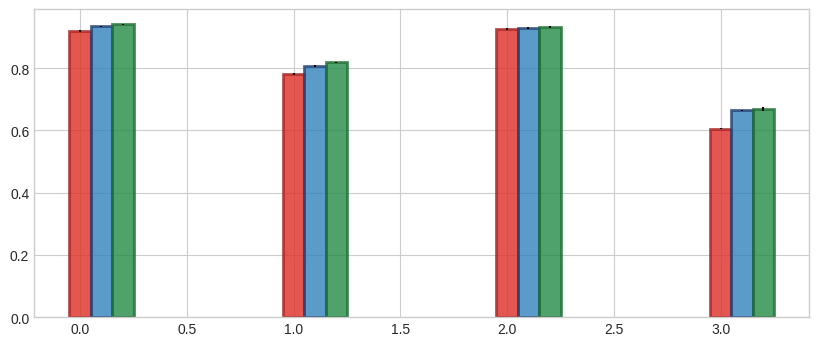

In [8]:
# plot_bar_res(vanilla_df, color_map=color_map, edgecolor_map=edgecolor_map)
plot_bar_res(df, bar_width=0.1, color_map=color_map, edgecolor_map=edgecolor_map,
remap_name=remap_name, metric='final_acc')